In [1]:
import os
import numpy  as np 
import warnings
warnings.filterwarnings("ignore")

import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM, Reshape
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-10-24 08:47:38.061129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 08:47:38.061258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 08:47:38.207526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


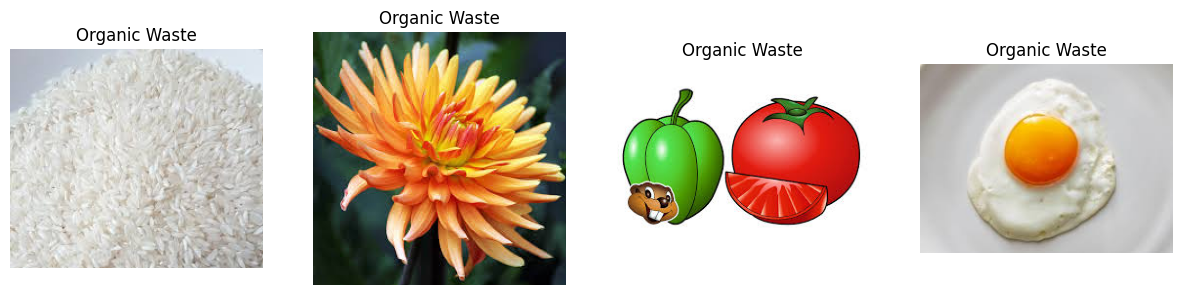

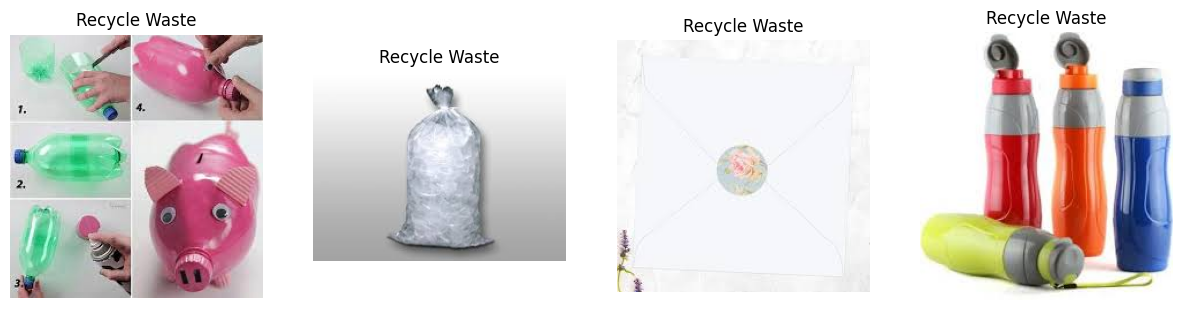

In [2]:
def plot_random_images(dataset_dir, category, num_images=4):
    # Path to the specified category directory
    category_dir = os.path.join(dataset_dir, 'TRAIN', category)
    
    # Get the list of image file names in the category directory
    image_files = os.listdir(category_dir)
    
    # Select num_images random images from the category directory
    random_images = random.sample(image_files, num_images)
    
    # Plot the random images
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(random_images):
        # Load the image
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        
        # Plot the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")  # Set the title for each image
        plt.axis('off')
    
    plt.show()

# Example usage: plot 4 random images from 'O' (Organic) and 'R' (Recyclable) categories
dataset_dir = '/kaggle/input/waste-classification-data/DATASET'
plot_random_images(dataset_dir, 'O', num_images=4)
plot_random_images(dataset_dir, 'R', num_images=4)

In [3]:
train_directory = '/kaggle/input/waste-classification-data/DATASET/TRAIN'
test_directory = '/kaggle/input/waste-classification-data/DATASET/TEST'

In [4]:
train_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

validation_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)

test_data_generator = ImageDataGenerator(
    #rescale = 1./255,
    preprocessing_function=preprocess_input
)

In [5]:
train_generator = train_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="training",
    seed = 43
)

Found 18052 images belonging to 2 classes.


In [6]:
validation_generator = validation_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="validation",
    seed = 43
)

Found 4512 images belonging to 2 classes.


In [7]:
test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True
)

Found 2513 images belonging to 2 classes.


In [8]:
print(f"Number of images in the training set: {train_generator.n}")
print(f"Number of images in the validation set: {validation_generator.n}")
print(f"Number of images in the training set: {test_generator.n}")

Number of images in the training set: 18052
Number of images in the validation set: 4512
Number of images in the training set: 2513


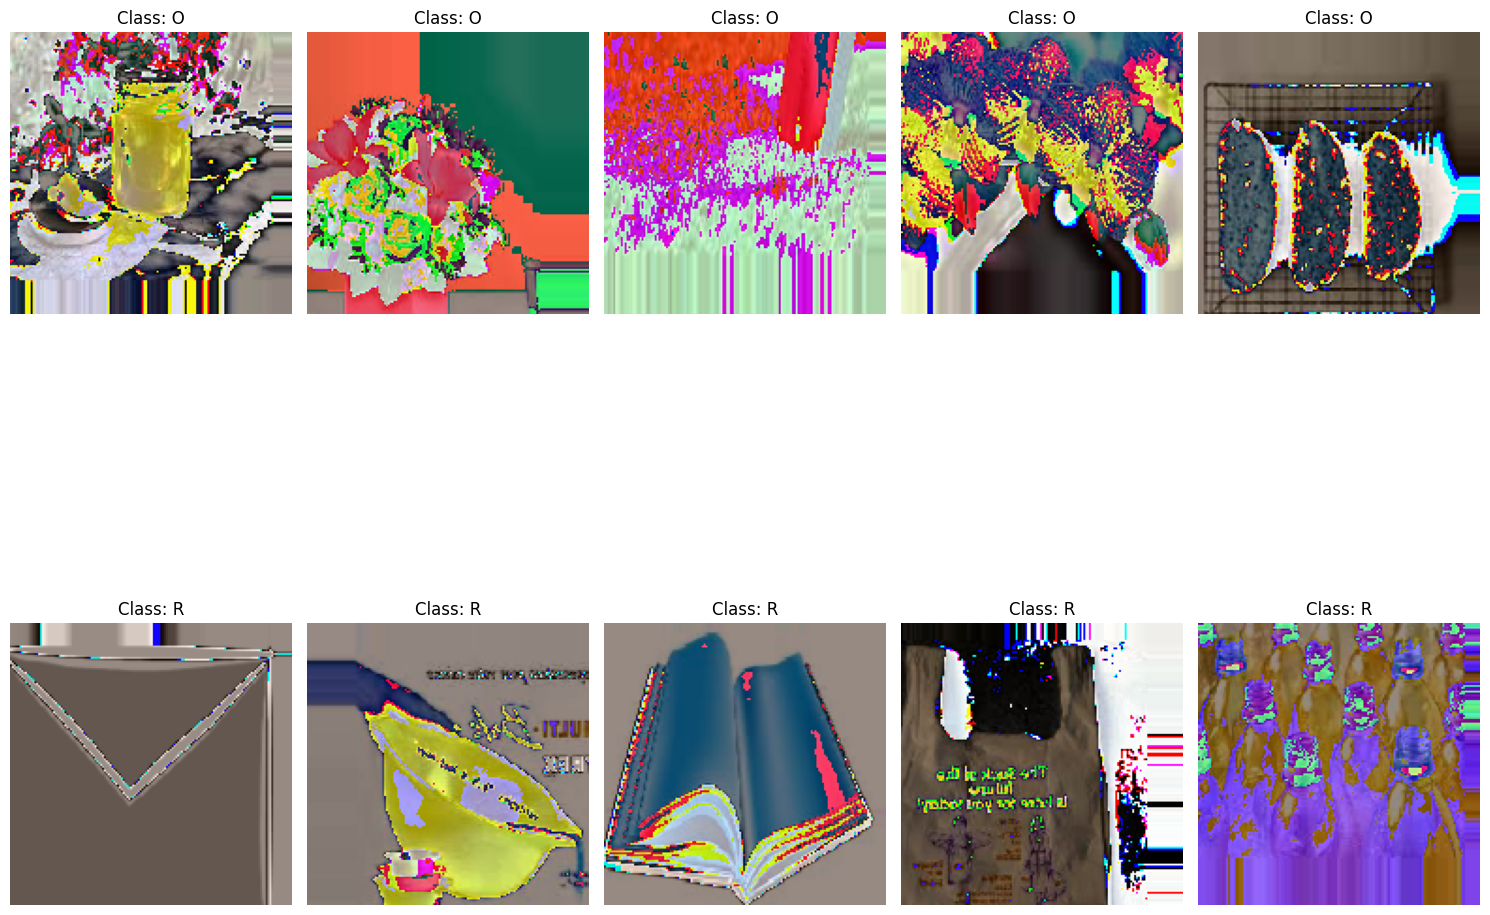

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Function to plot and display augmented images
def plot_augmented_images(generator, class_names, n_images_per_class=5):
    plt.figure(figsize=(15, 15))

    # Loop through each class
    for class_idx, class_name in enumerate(class_names):
        generator.reset()  # Reset the generator to start from the beginning
        images, labels = next(generator)  # Get a batch of images and labels

        # If the labels are 1D (binary classification), reshape them
        if len(labels.shape) == 1:
            labels = np.eye(len(class_names))[labels.astype(int)]  # Convert 1D labels to one-hot

        # Find the images that belong to the current class
        class_images = images[np.where(labels[:, class_idx] == 1)]

        # Plot a few images for the current class
        for i in range(min(n_images_per_class, len(class_images))):
            plt.subplot(len(class_names), n_images_per_class, class_idx * n_images_per_class + i + 1)
            plt.imshow(class_images[i].astype(np.uint8))  # Display the image
            plt.title(f"Class: {class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Plot a few augmented images for each class
plot_augmented_images(train_generator, class_names)

In [10]:
# Define the core VGG16 model with pre-trained weights
core = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
core.trainable = False

# Define the sequential model
model = Sequential([
    core,
    Flatten(),
    Dense(100, activation="relu"),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Define early stopping callback
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

# Define model checkpoint callback based on validation accuracy
checkpoint_path = "model_checkpoint.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[earlystopping, checkpoint])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1729759782.616129     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1729759782.641395     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/142 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8197 - loss: 1.0881

W0000 00:00:1729759961.413909     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8261 - loss: 0.9981

W0000 00:00:1729759992.242573     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729760043.287423     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.91534, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.8263 - loss: 0.9951 - val_accuracy: 0.9153 - val_loss: 0.2378
Epoch 2/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.8939 - loss: 0.2998
Epoch 2: val_accuracy improved from 0.91534 to 0.92110, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 118s 793ms/step - accuracy: 0.8939 - loss: 0.2997 - val_accuracy: 0.9211 - val_loss: 0.2151
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9065 - loss: 0.2537
Epoch 3: val_accuracy improved from 0.92110 to 0.92332, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 116s 783ms/step - accuracy: 0.9065 - loss: 0.2537 - val_accuracy: 0.9233 - val_loss: 0.2111
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.9171 - loss: 0.2221
Epoch 4: val_accuracy improved from 0.92332 to 0.92797, saving model to model_checkpoint.kera

In [11]:
evaluation = model.evaluate(test_generator)
print(f'test Loss: {evaluation[0]:.4f}')
print(f'test Accuracy: {evaluation[1] * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9069 - loss: 0.3408
test Loss: 0.3621
test Accuracy: 89.81%


W0000 00:00:1729761663.790882     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


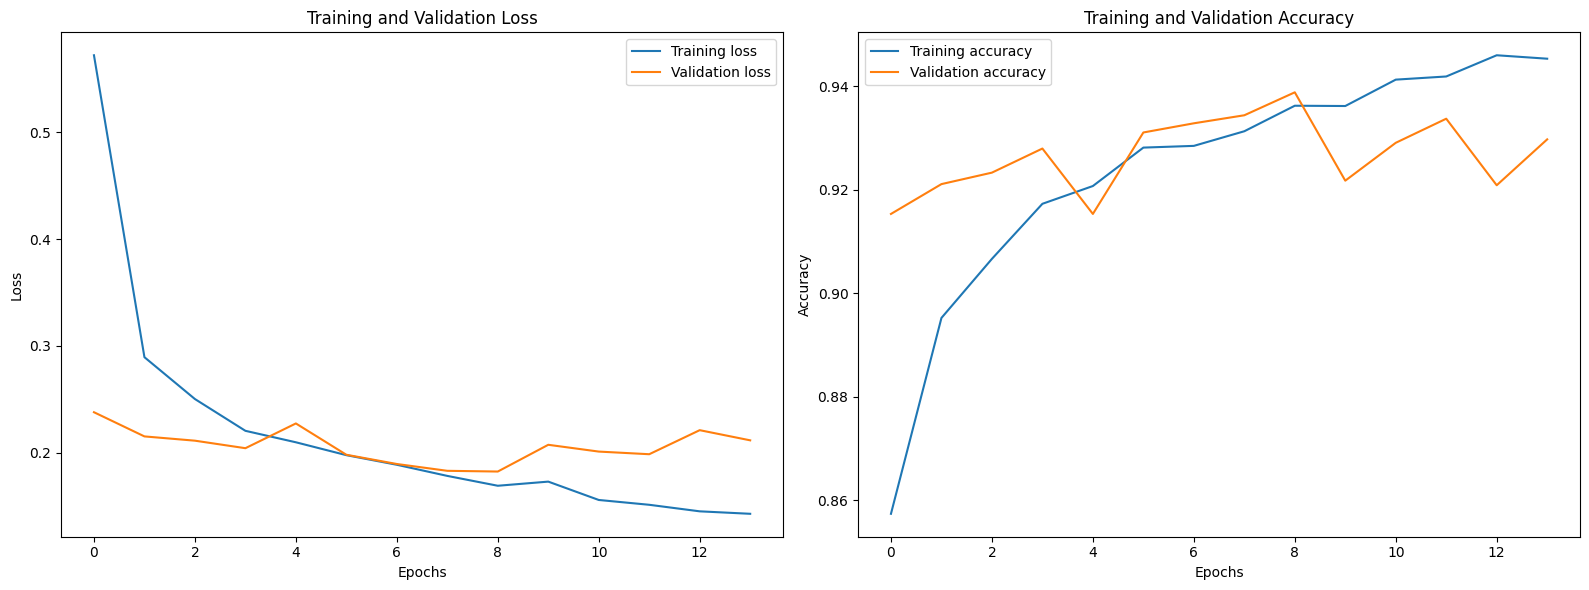

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(12, 5)):
    num_metrics = len(metrics)
    plt.figure(figsize=figsize)
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, i)
        plt.plot(history.epoch, history.history[metric], label='Training ' + metric)
        plt.plot(history.epoch, history.history['val_' + metric], label='Validation ' + metric)
        plt.title('Training and Validation ' + metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(16, 6))


In [13]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

In [14]:
# Generate predictions on the validation set
val_predictions = model.predict(validation_generator)

 1/36 ━━━━━━━━━━━━━━━━━━━━ 34s 975ms/step

W0000 00:00:1729761703.836246     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step


W0000 00:00:1729761714.447779     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [15]:
# Convert probabilities to binary predictions
val_predictions_binary = np.where(val_predictions > 0.5, 1, 0)

In [16]:
# Get true labels
val_true_labels = validation_generator.classes

# Compute precision, recall, and F1 score
precision = precision_score(val_true_labels, val_predictions_binary)
recall = recall_score(val_true_labels, val_predictions_binary)
f1 = f1_score(val_true_labels, val_predictions_binary)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Alternatively, use classification_report for a detailed report
print(classification_report(val_true_labels, val_predictions_binary))

Precision: 0.4424
Recall: 0.4402
F1 Score: 0.4413
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2513
           1       0.44      0.44      0.44      1999

    accuracy                           0.51      4512
   macro avg       0.50      0.50      0.50      4512
weighted avg       0.51      0.51      0.51      4512

